<a href="https://colab.research.google.com/github/TzRRR/CS4774-Machine_Learning/blob/main/%E2%80%9CCS_4774_Assignment_2_ipynb%E2%80%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2: Clustering California Housing with K-means

---
## 1. PRE-PROCESSING THE DATA

In [ ]:
import pandas as pd
import numpy as np
from pandas.plotting import scatter_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

housing = pd.read_csv('housing.csv')
housing.info()
housing.describe()

In [ ]:
from sklearn.model_selection import train_test_split
# Split the data into train set (80%) and test set (20%)
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [ ]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis = 1, inplace=True)

housing = strat_train_set.copy()
housing.plot(kind="scatter", x="longitude", y="latitude")
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()

import matplotlib.image as mpimg
ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                       s=housing['population']/100, label="Population",
                       c="median_house_value", cmap=plt.get_cmap("jet"),
                       colorbar=False, alpha=0.4,
                      )

plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)

plt.legend(fontsize=16)
plt.show()

In [ ]:
# Data processing using pipelines
housing = strat_train_set.drop("median_house_value", axis=1)

from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
housing_numerics = housing.select_dtypes(include=numerics)

imputer.fit(housing_numerics)
X = imputer.transform(housing_numerics)
train_tr = pd.DataFrame(X, columns=housing_numerics.columns,
                          index=housing.index)

housing_cat = train_set.select_dtypes(exclude = numerics)
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)


num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

train_numerics_tr = num_pipeline.fit_transform(housing_numerics)

from sklearn.compose import ColumnTransformer

num_attribs = list(housing_numerics)
cat_attribs = list(housing_cat)

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(handle_unknown='ignore'), cat_attribs),
    ])

cat_col_names = list(cat_encoder.categories_[0])

train_set_prepared = full_pipeline.fit_transform(train_set)
housing_tr = pd.DataFrame(train_set_prepared, columns=num_attribs+cat_col_names, index=housing.index)
housing_tr

- - -
## 2. IMPLEMENTING K-MEANS AND CLUSTERING

In [ ]:
from math import *
from decimal import Decimal

def p_root(value, root):

    root_value = 1 / float(root)
    return round (Decimal(value) **
             Decimal(root_value), 3)

def minkowski_distance(x, y, p_value):

    # pass the p_root function to calculate all the value of vector parallelly
    return (p_root(sum(pow(abs(a-b), p_value)
            for a, b in zip(x, y)), p_value))

def initial_centroids(k, data):
    centroids = data.sample(k)
    return centroids

def cluster(reference, data):
    k = reference.shape[0]
    n = data.shape[0]
    clusters = []
    cluster_distance = []

    for point in range(n):
      distance_list = np.array([])
      for centroid in range(k):
        distance = minkowski_distance(reference.iloc[centroid,:], data.iloc[point,:], 2)
        distance_list = np.append(distance_list, distance)

      nearest_centroid = np.where(distance_list == np.min(distance_list))[0].tolist()[0]
      nearest_centroid_distance = np.min(distance_list)
      clusters.append(nearest_centroid)
      cluster_distance.append(nearest_centroid_distance)

    return clusters, cluster_distance

def k_means(k, data):
    centroids = initial_centroids(k, data)
    different = True
    i = 0
    distances_to_centroids = []

    while(different == True):
      data['cluster_list'], distance = cluster(centroids, data)
      centroids = data.groupby('cluster_list').agg('mean').reset_index(drop = True)
      distances_to_centroids.append(sum(distance))
      if i > 0:
        if distances_to_centroids[i] - distances_to_centroids[i-1] < 0.001:
          different = False
      i = i + 1

    return data['cluster_list'], distance, centroids

In [ ]:
housing_tr['cluster_list'], housing_tr['distance'], centroids = k_means(2, housing_tr)

In [ ]:
stats2 = pd.DataFrame()
mask = housing_tr['cluster_list'] == 0
stats2['cluster1_mean'] = housing_tr.loc[mask, :].mean()
stats2['cluster2_mean'] = housing_tr.loc[~mask, :].mean()
stats2['cluster1_std'] = housing_tr.loc[mask, :].std()
stats2['cluster2_std'] = housing_tr.loc[~mask, :].std()
sse = np.sum((housing_tr['distance'])**2)

<function matplotlib.pyplot.show(close=None, block=None)>

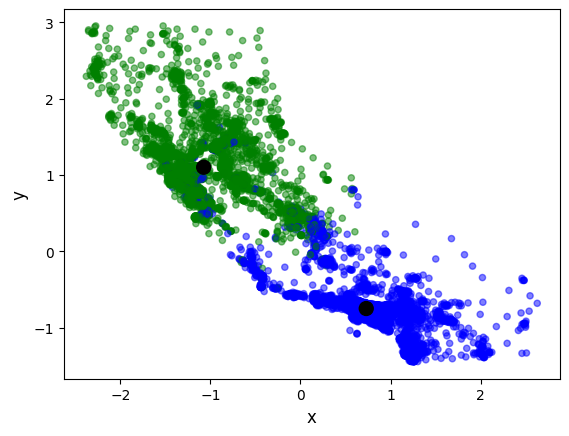

In [ ]:
points_color = ListedColormap(['blue', 'green'])
centroids_color = ListedColormap(['black','black'])
plt.scatter(housing_tr.iloc[:,0], housing_tr.iloc[:, 1], marker = 'o',
            c = housing_tr['cluster_list'].astype('category'), cmap = points_color, s = 20, alpha = 0.5)
plt.scatter(centroids.iloc[:,0], centroids.iloc[:,1], marker = ('o'), s = 100, c = [0,1], cmap = centroids_color)
plt.xlabel(r'x', fontsize = 12)
plt.ylabel(r'y', fontsize = 12)
plt.show


<ipython-input-40-4dfa128a7e40>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  centroids = data.groupby('cluster_list').agg('mean').reset_index(drop = True)
<ipython-input-40-4dfa128a7e40>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  centroids = data.groupby('cluster_list').agg('mean').reset_index(drop = True)


                    clusters1_mean  clusters2_mean  clusters3_mean  \
longitude                -1.059939        0.776390        0.203428   
latitude                  1.088910       -0.801437       -0.194012   
housing_median_age        0.111675        0.136347       -0.875274   
total_rooms              -0.243570       -0.279688        1.839773   
total_bedrooms           -0.282855       -0.270893        1.925519   
population               -0.313317       -0.206198        1.765478   
households               -0.287970       -0.264734        1.917056   
median_income            -0.063004        0.012336        0.144438   
<1H OCEAN                 0.174901        0.644954        0.485273   
INLAND                    0.461405        0.199482        0.331724   
ISLAND                    0.000000        0.000493        0.000000   
NEAR BAY                  0.268824        0.000000        0.072912   
NEAR OCEAN                0.094870        0.155070        0.110092   
cluster_list        

<ipython-input-40-4dfa128a7e40>:61: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  centroids = data.groupby('cluster_list').agg('mean').reset_index(drop = True)
<ipython-input-49-c28f94e4c22f>:6: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  stats3['clusters1_std'] = housing_tr.loc[housing_tr['cluster_list'] == 0, :].std()
<ipython-input-49-c28f94e4c22f>:7: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or s

<function matplotlib.pyplot.show(close=None, block=None)>

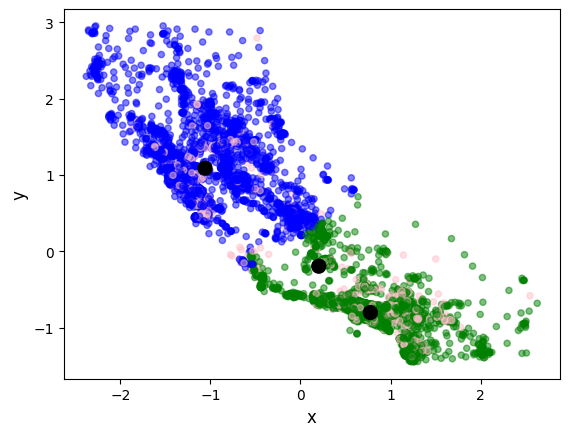

In [ ]:
housing_tr['cluster_list'], housing_tr['distance'], centroids = k_means(3, housing_tr)
stats3 = pd.DataFrame()
stats3['clusters1_mean'] = housing_tr.loc[housing_tr['cluster_list'] == 0, :].mean()
stats3['clusters2_mean'] = housing_tr.loc[housing_tr['cluster_list'] == 1, :].mean()
stats3['clusters3_mean'] = housing_tr.loc[housing_tr['cluster_list'] == 2, :].mean()
stats3['clusters1_std'] = housing_tr.loc[housing_tr['cluster_list'] == 0, :].std()
stats3['clusters2_std'] = housing_tr.loc[housing_tr['cluster_list'] == 1, :].std()
stats3['clusters3_std'] = housing_tr.loc[housing_tr['cluster_list'] == 2, :].std()
sse = np.sum((housing_tr['distance'])**2)
print(stats3)
print(sse)

points_color = ListedColormap(['blue', 'green', 'pink'])
centroids_color = ListedColormap(['black','black','black'])
plt.scatter(housing_tr.iloc[:,0], housing_tr.iloc[:, 1], marker = 'o',
            c = housing_tr['cluster_list'].astype('category'), cmap = points_color, s = 20, alpha = 0.5)
plt.scatter(centroids.iloc[:,0], centroids.iloc[:,1], marker = ('o'), s = 100, c = [0,1,2], cmap = centroids_color)
plt.xlabel(r'x', fontsize = 12)
plt.ylabel(r'y', fontsize = 12)
plt.show

<ipython-input-40-4dfa128a7e40>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  centroids = data.groupby('cluster_list').agg('mean').reset_index(drop = True)
<ipython-input-40-4dfa128a7e40>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  centroids = data.groupby('cluster_list').agg('mean').reset_index(drop = True)


                    clusters1_mean  clusters2_mean  clusters3_mean  \
longitude                -1.142392        0.802937       -0.857545   
latitude                  1.025845       -0.828250        1.077539   
housing_median_age        0.879484        0.119898       -0.785361   
total_rooms              -0.437751       -0.238711       -0.057728   
total_bedrooms           -0.460778       -0.204557       -0.086512   
population               -0.490634       -0.145961       -0.119786   
households               -0.456486       -0.200172       -0.108736   
median_income            -0.103113       -0.010832       -0.169762   
<1H OCEAN                 0.146091        0.656941        0.192616   
INLAND                    0.323045        0.185509        0.667737   
ISLAND                    0.000000        0.000486        0.000000   
NEAR BAY                  0.408289        0.000000        0.081862   
NEAR OCEAN                0.122575        0.157063        0.057785   
cluster_list        

<ipython-input-40-4dfa128a7e40>:61: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  centroids = data.groupby('cluster_list').agg('mean').reset_index(drop = True)
<ipython-input-50-210346abc09e>:7: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  stats4['clusters1_std'] = housing_tr.loc[housing_tr['cluster_list'] == 0, :].std()
<ipython-input-50-210346abc09e>:8: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or s

<function matplotlib.pyplot.show(close=None, block=None)>

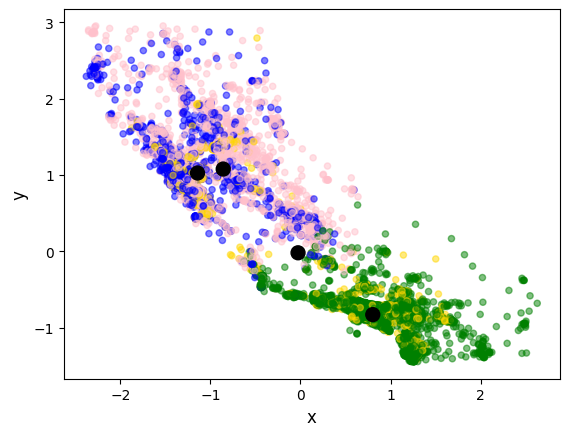

In [ ]:
housing_tr['cluster_list'], housing_tr['distance'], centroids = k_means(4, housing_tr)
stats4 = pd.DataFrame()
stats4['clusters1_mean'] = housing_tr.loc[housing_tr['cluster_list'] == 0, :].mean()
stats4['clusters2_mean'] = housing_tr.loc[housing_tr['cluster_list'] == 1, :].mean()
stats4['clusters3_mean'] = housing_tr.loc[housing_tr['cluster_list'] == 2, :].mean()
stats4['clusters4_mean'] = housing_tr.loc[housing_tr['cluster_list'] == 3, :].mean()
stats4['clusters1_std'] = housing_tr.loc[housing_tr['cluster_list'] == 0, :].std()
stats4['clusters2_std'] = housing_tr.loc[housing_tr['cluster_list'] == 1, :].std()
stats4['clusters3_std'] = housing_tr.loc[housing_tr['cluster_list'] == 2, :].std()
stats4['clusters4_std'] = housing_tr.loc[housing_tr['cluster_list'] == 3, :].std()
sse = np.sum((housing_tr['distance'])**2)
print(stats4)
print(sse)

points_color = ListedColormap(['blue', 'green', 'pink', 'gold'])
centroids_color = ListedColormap(['black','black','black','black'])
plt.scatter(housing_tr.iloc[:,0], housing_tr.iloc[:, 1], marker = 'o',
            c = housing_tr['cluster_list'].astype('category'), cmap = points_color, s = 20, alpha = 0.5)
plt.scatter(centroids.iloc[:,0], centroids.iloc[:,1], marker = ('o'), s = 100, c = [0,1,2,3], cmap = centroids_color)
plt.xlabel(r'x', fontsize = 12)
plt.ylabel(r'y', fontsize = 12)
plt.show

<ipython-input-11-4dfa128a7e40>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  centroids = data.groupby('cluster_list').agg('mean').reset_index(drop = True)
<ipython-input-11-4dfa128a7e40>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  centroids = data.groupby('cluster_list').agg('mean').reset_index(drop = True)


                    clusters1_mean  clusters2_mean  clusters3_mean  \
longitude                -1.237069       -1.183947        0.257960   
latitude                  1.176762        1.053846       -0.243619   
housing_median_age       -0.233076        1.267334       -0.874753   
total_rooms               0.029133       -0.469937        1.793759   
total_bedrooms           -0.055114       -0.448190        1.886472   
population               -0.077226       -0.501763        1.728009   
households               -0.037502       -0.446989        1.876928   
median_income             0.307072       -0.357976        0.131087   
<1H OCEAN                 0.310408        0.085372        0.489461   
INLAND                    0.340975        0.301199        0.332084   
ISLAND                    0.000000        0.000000        0.000000   
NEAR BAY                  0.226710        0.504077        0.066511   
NEAR OCEAN                0.121907        0.109353        0.111944   
cluster_list        

<ipython-input-11-4dfa128a7e40>:61: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  centroids = data.groupby('cluster_list').agg('mean').reset_index(drop = True)
<ipython-input-14-160d1f3fb92c>:8: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  stats5['clusters1_std'] = housing_tr.loc[housing_tr['cluster_list'] == 0, :].std()
<ipython-input-14-160d1f3fb92c>:9: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or s

<function matplotlib.pyplot.show(close=None, block=None)>

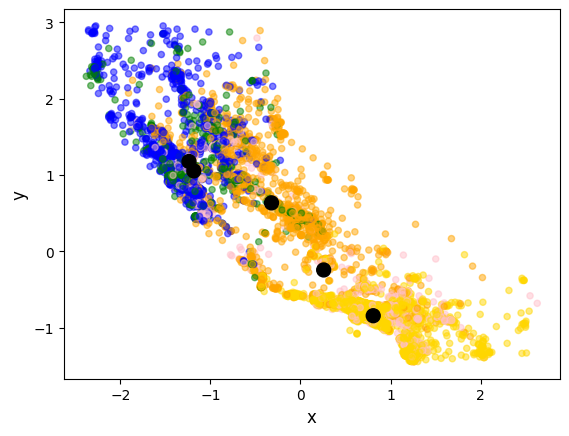

In [ ]:
housing_tr['cluster_list'], housing_tr['distance'], centroids = k_means(5, housing_tr)
stats5 = pd.DataFrame()
stats5['clusters1_mean'] = housing_tr.loc[housing_tr['cluster_list'] == 0, :].mean()
stats5['clusters2_mean'] = housing_tr.loc[housing_tr['cluster_list'] == 1, :].mean()
stats5['clusters3_mean'] = housing_tr.loc[housing_tr['cluster_list'] == 2, :].mean()
stats5['clusters4_mean'] = housing_tr.loc[housing_tr['cluster_list'] == 3, :].mean()
stats5['clusters5_mean'] = housing_tr.loc[housing_tr['cluster_list'] == 4, :].mean()
stats5['clusters1_std'] = housing_tr.loc[housing_tr['cluster_list'] == 0, :].std()
stats5['clusters2_std'] = housing_tr.loc[housing_tr['cluster_list'] == 1, :].std()
stats5['clusters3_std'] = housing_tr.loc[housing_tr['cluster_list'] == 2, :].std()
stats5['clusters4_std'] = housing_tr.loc[housing_tr['cluster_list'] == 3, :].std()
stats5['clusters5_std'] = housing_tr.loc[housing_tr['cluster_list'] == 4, :].std()
sse = np.sum((housing_tr['distance'])**2)
print(stats5)
print(sse)

points_color = ListedColormap(['blue', 'green', 'pink', 'gold', 'orange'])
centroids_color = ListedColormap(['black','black','black','black','black'])
plt.scatter(housing_tr.iloc[:,0], housing_tr.iloc[:, 1], marker = 'o',
            c = housing_tr['cluster_list'].astype('category'), cmap = points_color, s = 20, alpha = 0.5)
plt.scatter(centroids.iloc[:,0], centroids.iloc[:,1], marker = ('o'), s = 100, c = [0,1,2,3,4], cmap = centroids_color)
plt.xlabel(r'x', fontsize = 12)
plt.ylabel(r'y', fontsize = 12)
plt.show

<ipython-input-11-4dfa128a7e40>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  centroids = data.groupby('cluster_list').agg('mean').reset_index(drop = True)
<ipython-input-11-4dfa128a7e40>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  centroids = data.groupby('cluster_list').agg('mean').reset_index(drop = True)


                    clusters1_mean  clusters2_mean  clusters3_mean  \
longitude                -1.312285        0.803533       -1.344731   
latitude                  1.031961       -0.832421        1.058108   
housing_median_age        1.480266        0.106400       -0.050208   
total_rooms              -0.315442       -0.217457       -0.473251   
total_bedrooms           -0.274926       -0.190034       -0.538965   
population               -0.364328       -0.134300       -0.545666   
households               -0.265372       -0.185470       -0.533916   
median_income            -0.197765        0.007165        0.349933   
<1H OCEAN                 0.072581        0.663365        0.425185   
INLAND                    0.104839        0.179249        0.082963   
ISLAND                    0.000000        0.000483        0.000000   
NEAR BAY                  0.704973        0.000000        0.279259   
NEAR OCEAN                0.117608        0.156903        0.212593   
cluster_list        

<ipython-input-11-4dfa128a7e40>:61: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  centroids = data.groupby('cluster_list').agg('mean').reset_index(drop = True)
<ipython-input-15-4ee1484f2b5f>:9: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  stats6['clusters1_std'] = housing_tr.loc[housing_tr['cluster_list'] == 0, :].std()
<ipython-input-15-4ee1484f2b5f>:10: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or 

<function matplotlib.pyplot.show(close=None, block=None)>

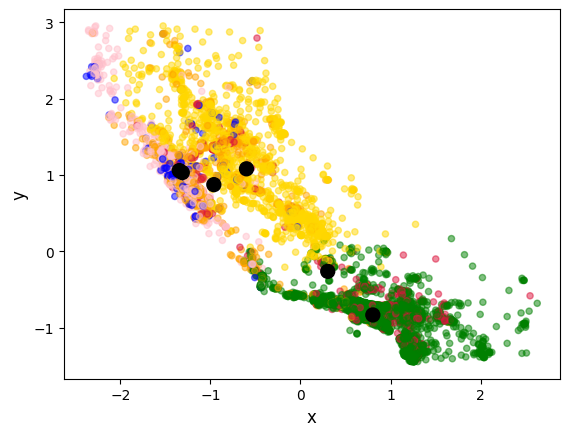

In [ ]:
housing_tr['cluster_list'], housing_tr['distance'], centroids = k_means(6, housing_tr)
stats6 = pd.DataFrame()
stats6['clusters1_mean'] = housing_tr.loc[housing_tr['cluster_list'] == 0, :].mean()
stats6['clusters2_mean'] = housing_tr.loc[housing_tr['cluster_list'] == 1, :].mean()
stats6['clusters3_mean'] = housing_tr.loc[housing_tr['cluster_list'] == 2, :].mean()
stats6['clusters4_mean'] = housing_tr.loc[housing_tr['cluster_list'] == 3, :].mean()
stats6['clusters5_mean'] = housing_tr.loc[housing_tr['cluster_list'] == 4, :].mean()
stats6['clusters6_mean'] = housing_tr.loc[housing_tr['cluster_list'] == 5, :].mean()
stats6['clusters1_std'] = housing_tr.loc[housing_tr['cluster_list'] == 0, :].std()
stats6['clusters2_std'] = housing_tr.loc[housing_tr['cluster_list'] == 1, :].std()
stats6['clusters3_std'] = housing_tr.loc[housing_tr['cluster_list'] == 2, :].std()
stats6['clusters4_std'] = housing_tr.loc[housing_tr['cluster_list'] == 3, :].std()
stats6['clusters5_std'] = housing_tr.loc[housing_tr['cluster_list'] == 4, :].std()
stats6['clusters6_std'] = housing_tr.loc[housing_tr['cluster_list'] == 5, :].std()
sse = np.sum((housing_tr['distance'])**2)
print(stats6)
print(sse)

points_color = ListedColormap(['blue', 'green', 'pink', 'gold', 'orange', 'crimson'])
centroids_color = ListedColormap(['black','black','black','black','black','black'])
plt.scatter(housing_tr.iloc[:,0], housing_tr.iloc[:, 1], marker = 'o',
            c = housing_tr['cluster_list'].astype('category'), cmap = points_color, s = 20, alpha = 0.5)
plt.scatter(centroids.iloc[:,0], centroids.iloc[:,1], marker = ('o'), s = 100, c = [0,1,2,3,4,5], cmap = centroids_color)
plt.xlabel(r'x', fontsize = 12)
plt.ylabel(r'y', fontsize = 12)
plt.show

<ipython-input-11-4dfa128a7e40>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  centroids = data.groupby('cluster_list').agg('mean').reset_index(drop = True)
<ipython-input-11-4dfa128a7e40>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  centroids = data.groupby('cluster_list').agg('mean').reset_index(drop = True)


                    clusters1_mean  clusters2_mean  clusters3_mean  \
longitude                -0.850806        0.867491        0.559791   
latitude                  1.151622       -0.875574       -0.613956   
housing_median_age       -0.779517       -0.692926        0.553956   
total_rooms              -0.124795        0.195023       -0.001674   
total_bedrooms           -0.146520        0.146110        0.327445   
population               -0.197661        0.116402        0.519158   
households               -0.179196        0.144100        0.342529   
median_income            -0.353045        0.323688       -0.719677   
<1H OCEAN                 0.138870        0.613236        0.656856   
INLAND                    0.741800        0.203193        0.220736   
ISLAND                    0.000000        0.000000        0.000669   
NEAR BAY                  0.071528        0.000000        0.001338   
NEAR OCEAN                0.047802        0.183572        0.120401   
cluster_list        

<ipython-input-11-4dfa128a7e40>:61: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  centroids = data.groupby('cluster_list').agg('mean').reset_index(drop = True)
<ipython-input-13-355058fcc0df>:10: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  stats7['clusters1_std'] = housing_tr.loc[housing_tr['cluster_list'] == 0, :].std()
<ipython-input-13-355058fcc0df>:11: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or

<function matplotlib.pyplot.show(close=None, block=None)>

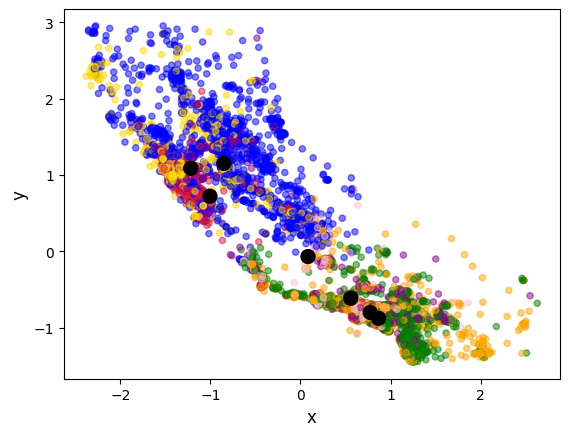

In [ ]:
housing_tr['cluster_list'], housing_tr['distance'], centroids = k_means(7, housing_tr)
stats7 = pd.DataFrame()
stats7['clusters1_mean'] = housing_tr.loc[housing_tr['cluster_list'] == 0, :].mean()
stats7['clusters2_mean'] = housing_tr.loc[housing_tr['cluster_list'] == 1, :].mean()
stats7['clusters3_mean'] = housing_tr.loc[housing_tr['cluster_list'] == 2, :].mean()
stats7['clusters4_mean'] = housing_tr.loc[housing_tr['cluster_list'] == 3, :].mean()
stats7['clusters5_mean'] = housing_tr.loc[housing_tr['cluster_list'] == 4, :].mean()
stats7['clusters6_mean'] = housing_tr.loc[housing_tr['cluster_list'] == 5, :].mean()
stats7['clusters7_mean'] = housing_tr.loc[housing_tr['cluster_list'] == 6, :].mean()
stats7['clusters1_std'] = housing_tr.loc[housing_tr['cluster_list'] == 0, :].std()
stats7['clusters2_std'] = housing_tr.loc[housing_tr['cluster_list'] == 1, :].std()
stats7['clusters3_std'] = housing_tr.loc[housing_tr['cluster_list'] == 2, :].std()
stats7['clusters4_std'] = housing_tr.loc[housing_tr['cluster_list'] == 3, :].std()
stats7['clusters5_std'] = housing_tr.loc[housing_tr['cluster_list'] == 4, :].std()
stats7['clusters6_std'] = housing_tr.loc[housing_tr['cluster_list'] == 5, :].std()
stats7['clusters7_std'] = housing_tr.loc[housing_tr['cluster_list'] == 6, :].std()
sse = np.sum((housing_tr['distance'])**2)
print(stats7)
print(sse)

points_color = ListedColormap(['blue', 'green', 'pink', 'gold', 'orange', 'crimson', 'darkmagenta'])
centroids_color = ListedColormap(['black','black','black','black','black','black','black'])
plt.scatter(housing_tr.iloc[:,0], housing_tr.iloc[:, 1], marker = 'o',
            c = housing_tr['cluster_list'].astype('category'), cmap = points_color, s = 20, alpha = 0.5)
plt.scatter(centroids.iloc[:,0], centroids.iloc[:,1], marker = ('o'), s = 100, c = [0,1,2,3,4,5,6], cmap = centroids_color)
plt.xlabel(r'x', fontsize = 12)
plt.ylabel(r'y', fontsize = 12)
plt.show

<ipython-input-40-4dfa128a7e40>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  centroids = data.groupby('cluster_list').agg('mean').reset_index(drop = True)
<ipython-input-40-4dfa128a7e40>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  centroids = data.groupby('cluster_list').agg('mean').reset_index(drop = True)


                    clusters1_mean  clusters2_mean  clusters3_mean  \
longitude                 0.975823       -0.821884        0.689668   
latitude                 -0.881490        1.125909       -0.785602   
housing_median_age       -1.002977       -0.589827        0.294564   
total_rooms               0.148195       -0.207565        0.072948   
total_bedrooms            0.211595       -0.203681        0.147662   
population                0.137879       -0.241171        0.257393   
households                0.168713       -0.234596        0.183866   
median_income            -0.091049       -0.457591        0.038684   
<1H OCEAN                 0.421192        0.127138        0.797113   
INLAND                    0.351435        0.760891        0.090309   
ISLAND                    0.000000        0.000000        0.000000   
NEAR BAY                  0.000000        0.062924        0.000000   
NEAR OCEAN                0.227373        0.049048        0.112577   
cluster_list        

<ipython-input-40-4dfa128a7e40>:61: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  centroids = data.groupby('cluster_list').agg('mean').reset_index(drop = True)
<ipython-input-54-08a09d246665>:11: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  stats8['clusters1_std'] = housing_tr.loc[housing_tr['cluster_list'] == 0, :].std()
<ipython-input-54-08a09d246665>:12: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or

<function matplotlib.pyplot.show(close=None, block=None)>

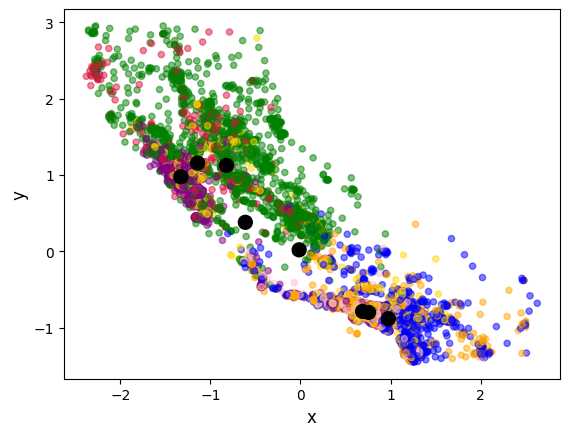

In [ ]:
housing_tr['cluster_list'], housing_tr['distance'], centroids = k_means(8, housing_tr)
stats8 = pd.DataFrame()
stats8['clusters1_mean'] = housing_tr.loc[housing_tr['cluster_list'] == 0, :].mean()
stats8['clusters2_mean'] = housing_tr.loc[housing_tr['cluster_list'] == 1, :].mean()
stats8['clusters3_mean'] = housing_tr.loc[housing_tr['cluster_list'] == 2, :].mean()
stats8['clusters4_mean'] = housing_tr.loc[housing_tr['cluster_list'] == 3, :].mean()
stats8['clusters5_mean'] = housing_tr.loc[housing_tr['cluster_list'] == 4, :].mean()
stats8['clusters6_mean'] = housing_tr.loc[housing_tr['cluster_list'] == 5, :].mean()
stats8['clusters7_mean'] = housing_tr.loc[housing_tr['cluster_list'] == 6, :].mean()
stats8['clusters8_mean'] = housing_tr.loc[housing_tr['cluster_list'] == 7, :].mean()
stats8['clusters1_std'] = housing_tr.loc[housing_tr['cluster_list'] == 0, :].std()
stats8['clusters2_std'] = housing_tr.loc[housing_tr['cluster_list'] == 1, :].std()
stats8['clusters3_std'] = housing_tr.loc[housing_tr['cluster_list'] == 2, :].std()
stats8['clusters4_std'] = housing_tr.loc[housing_tr['cluster_list'] == 3, :].std()
stats8['clusters5_std'] = housing_tr.loc[housing_tr['cluster_list'] == 4, :].std()
stats8['clusters6_std'] = housing_tr.loc[housing_tr['cluster_list'] == 5, :].std()
stats8['clusters7_std'] = housing_tr.loc[housing_tr['cluster_list'] == 6, :].std()
stats8['clusters8_std'] = housing_tr.loc[housing_tr['cluster_list'] == 7, :].std()
sse = np.sum((housing_tr['distance'])**2)
print(stats8)
print(sse)

points_color = ListedColormap(['blue', 'green', 'pink', 'gold', 'orange', 'crimson', 'darkmagenta','purple'])
centroids_color = ListedColormap(['black','black','black','black','black','black','black','black'])
plt.scatter(housing_tr.iloc[:,0], housing_tr.iloc[:, 1], marker = 'o',
            c = housing_tr['cluster_list'].astype('category'), cmap = points_color, s = 20, alpha = 0.5)
plt.scatter(centroids.iloc[:,0], centroids.iloc[:,1], marker = ('o'), s = 100, c = [0,1,2,3,4,5,6,7], cmap = centroids_color)
plt.xlabel(r'x', fontsize = 12)
plt.ylabel(r'y', fontsize = 12)
plt.show

<ipython-input-40-4dfa128a7e40>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  centroids = data.groupby('cluster_list').agg('mean').reset_index(drop = True)
<ipython-input-40-4dfa128a7e40>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  centroids = data.groupby('cluster_list').agg('mean').reset_index(drop = True)


                    clusters1_mean  clusters2_mean  clusters3_mean  \
longitude                -0.480853        0.429482       -1.047523   
latitude                  0.229750       -0.095187        1.019932   
housing_median_age        0.129582       -0.520508       -0.540232   
total_rooms              -0.097437       -0.441013        0.535054   
total_bedrooms           -0.462317       -0.418439        0.532631   
population               -0.422219       -0.375306        0.444109   
households               -0.431416       -0.457004        0.553269   
median_income             2.591193       -0.722666       -0.015900   
<1H OCEAN                 0.548619        0.044575        0.262851   
INLAND                    0.084034        0.888141        0.431373   
ISLAND                    0.000000        0.000000        0.000000   
NEAR BAY                  0.219688        0.000000        0.206147   
NEAR OCEAN                0.147659        0.067283        0.099629   
cluster_list        

<ipython-input-40-4dfa128a7e40>:61: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  centroids = data.groupby('cluster_list').agg('mean').reset_index(drop = True)
<ipython-input-55-505d7256929a>:12: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  stats9['clusters1_std'] = housing_tr.loc[housing_tr['cluster_list'] == 0, :].std()
<ipython-input-55-505d7256929a>:13: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or

<function matplotlib.pyplot.show(close=None, block=None)>

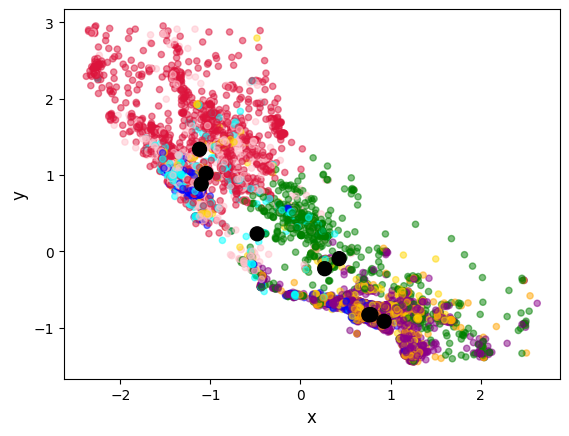

In [ ]:
housing_tr['cluster_list'], housing_tr['distance'], centroids = k_means(9, housing_tr)
stats9 = pd.DataFrame()
stats9['clusters1_mean'] = housing_tr.loc[housing_tr['cluster_list'] == 0, :].mean()
stats9['clusters2_mean'] = housing_tr.loc[housing_tr['cluster_list'] == 1, :].mean()
stats9['clusters3_mean'] = housing_tr.loc[housing_tr['cluster_list'] == 2, :].mean()
stats9['clusters4_mean'] = housing_tr.loc[housing_tr['cluster_list'] == 3, :].mean()
stats9['clusters5_mean'] = housing_tr.loc[housing_tr['cluster_list'] == 4, :].mean()
stats9['clusters6_mean'] = housing_tr.loc[housing_tr['cluster_list'] == 5, :].mean()
stats9['clusters7_mean'] = housing_tr.loc[housing_tr['cluster_list'] == 6, :].mean()
stats9['clusters8_mean'] = housing_tr.loc[housing_tr['cluster_list'] == 7, :].mean()
stats9['clusters9_mean'] = housing_tr.loc[housing_tr['cluster_list'] == 8, :].mean()
stats9['clusters1_std'] = housing_tr.loc[housing_tr['cluster_list'] == 0, :].std()
stats9['clusters2_std'] = housing_tr.loc[housing_tr['cluster_list'] == 1, :].std()
stats9['clusters3_std'] = housing_tr.loc[housing_tr['cluster_list'] == 2, :].std()
stats9['clusters4_std'] = housing_tr.loc[housing_tr['cluster_list'] == 3, :].std()
stats9['clusters5_std'] = housing_tr.loc[housing_tr['cluster_list'] == 4, :].std()
stats9['clusters6_std'] = housing_tr.loc[housing_tr['cluster_list'] == 5, :].std()
stats9['clusters7_std'] = housing_tr.loc[housing_tr['cluster_list'] == 6, :].std()
stats9['clusters8_std'] = housing_tr.loc[housing_tr['cluster_list'] == 7, :].std()
stats9['clusters9_std'] = housing_tr.loc[housing_tr['cluster_list'] == 8, :].std()
sse = np.sum((housing_tr['distance'])**2)
print(stats9)
print(sse)

points_color = ListedColormap(['blue', 'green', 'pink', 'gold', 'orange', 'crimson', 'darkmagenta','purple', 'cyan'])
centroids_color = ListedColormap(['black','black','black','black','black','black','black','black','black'])
plt.scatter(housing_tr.iloc[:,0], housing_tr.iloc[:, 1], marker = 'o',
            c = housing_tr['cluster_list'].astype('category'), cmap = points_color, s = 20, alpha = 0.5)
plt.scatter(centroids.iloc[:,0], centroids.iloc[:,1], marker = ('o'), s = 100, c = [0,1,2,3,4,5,6,7,8], cmap = centroids_color)
plt.xlabel(r'x', fontsize = 12)
plt.ylabel(r'y', fontsize = 12)
plt.show

                    clusters1_mean  clusters2_mean  clusters3_mean  \
longitude                -1.190026       -0.739866        0.681397   
latitude                  0.910647        1.145639       -0.786773   
housing_median_age       -0.377440       -0.578407        0.388608   
total_rooms              -0.051632       -0.444166       -0.342683   
total_bedrooms           -0.398920       -0.472695       -0.303680   
population               -0.318585       -0.494785       -0.191914   
households               -0.360487       -0.521583       -0.278320   
median_income             1.951420       -0.497303       -0.004982   
<1H OCEAN                 0.427326        0.069477        0.972806   
INLAND                    0.155523        0.867994        0.002060   
ISLAND                    0.000000        0.000000        0.000000   
NEAR BAY                  0.299419        0.037054        0.000000   
NEAR OCEAN                0.117733        0.025475        0.025134   
cluster_list        

<ipython-input-12-14bd6947e517>:13: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  stats10['clusters1_std'] = housing_tr.loc[housing_tr['cluster_list'] == 0, :].std()
<ipython-input-12-14bd6947e517>:14: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  stats10['clusters2_std'] = housing_tr.loc[housing_tr['cluster_list'] == 1, :].std()
<ipython-input-12-14bd6947e517>:15: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None

<function matplotlib.pyplot.show(close=None, block=None)>

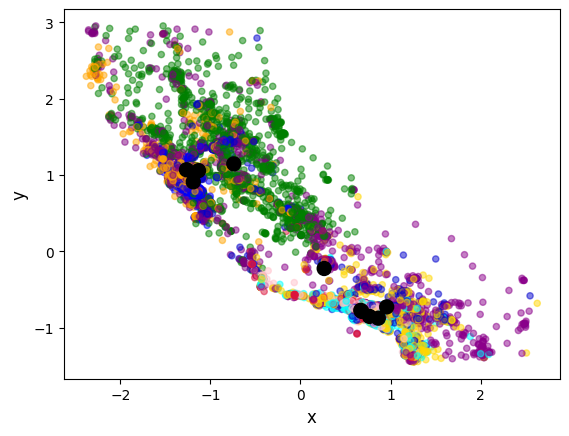

In [ ]:
housing_tr['cluster_list'], housing_tr['distance'], centroids = k_means(10, housing_tr)
stats10 = pd.DataFrame()
stats10['clusters1_mean'] = housing_tr.loc[housing_tr['cluster_list'] == 0, :].mean()
stats10['clusters2_mean'] = housing_tr.loc[housing_tr['cluster_list'] == 1, :].mean()
stats10['clusters3_mean'] = housing_tr.loc[housing_tr['cluster_list'] == 2, :].mean()
stats10['clusters4_mean'] = housing_tr.loc[housing_tr['cluster_list'] == 3, :].mean()
stats10['clusters5_mean'] = housing_tr.loc[housing_tr['cluster_list'] == 4, :].mean()
stats10['clusters6_mean'] = housing_tr.loc[housing_tr['cluster_list'] == 5, :].mean()
stats10['clusters7_mean'] = housing_tr.loc[housing_tr['cluster_list'] == 6, :].mean()
stats10['clusters8_mean'] = housing_tr.loc[housing_tr['cluster_list'] == 7, :].mean()
stats10['clusters9_mean'] = housing_tr.loc[housing_tr['cluster_list'] == 8, :].mean()
stats10['clusters10_mean'] = housing_tr.loc[housing_tr['cluster_list'] == 9, :].mean()
stats10['clusters1_std'] = housing_tr.loc[housing_tr['cluster_list'] == 0, :].std()
stats10['clusters2_std'] = housing_tr.loc[housing_tr['cluster_list'] == 1, :].std()
stats10['clusters3_std'] = housing_tr.loc[housing_tr['cluster_list'] == 2, :].std()
stats10['clusters4_std'] = housing_tr.loc[housing_tr['cluster_list'] == 3, :].std()
stats10['clusters5_std'] = housing_tr.loc[housing_tr['cluster_list'] == 4, :].std()
stats10['clusters6_std'] = housing_tr.loc[housing_tr['cluster_list'] == 5, :].std()
stats10['clusters7_std'] = housing_tr.loc[housing_tr['cluster_list'] == 6, :].std()
stats10['clusters8_std'] = housing_tr.loc[housing_tr['cluster_list'] == 7, :].std()
stats10['clusters9_std'] = housing_tr.loc[housing_tr['cluster_list'] == 8, :].std()
stats10['clusters10_std'] = housing_tr.loc[housing_tr['cluster_list'] == 9, :].std()
sse = np.sum((housing_tr['distance'])**2)
print(stats10)
print(sse)

points_color = ListedColormap(['blue', 'green', 'pink', 'gold', 'orange', 'crimson', 'darkmagenta','purple', 'cyan', 'mediumblue'])
centroids_color = ListedColormap(['black','black','black','black','black','black','black','black','black','black'])
plt.scatter(housing_tr.iloc[:,0], housing_tr.iloc[:, 1], marker = 'o',
            c = housing_tr['cluster_list'].astype('category'), cmap = points_color, s = 20, alpha = 0.5)
plt.scatter(centroids.iloc[:,0], centroids.iloc[:,1], marker = ('o'), s = 100, c = [0,1,2,3,4,5,6,7,8,9], cmap = centroids_color)
plt.xlabel(r'x', fontsize = 12)
plt.ylabel(r'y', fontsize = 12)
plt.show

As k increases, the gap between San Francisco and Los Anageles remains, and houses in these areas are further clustered into different groups. Degrees of economics development plays an important factor since some clusters centered on the two major cities and some clusters cover other rural areas. The Sillicon Valley is successfully identified to a independent cluster(lower centroid in the San Francisco area with blue distribution) compared to the upper orange distribution.

- - -
## 4. WRITING ON THE INTUITION FOR THE CALIFORNIA HOUSING CRISIS (10 pts)

This question is a qualitative one, and is intended to let you experiment with a real world clustering task. Hopefully it gives you some intuition as for how the preset number of clusters affects the clustering results. Too few clusters may not reveal the information that is in the data. Too many clusters may hurt data analysis as well, as it may not generalize (and in this sense, it is equivalent to over fitting).

Write at least one paragraph to demonstrate your intuition on the California Housing Crisis. You might also want to mention some possible solutions to solve it. You will receive credits based upon your insights and intuitions on this challenge.



According to the experiments of different k values, k ranging from 5 to 7 gives a fair clustering outcome. These clusters are mainly consitituted by: expensive house clusters in two major cities, relatively affordable house clusters in two major cities, some rural area housing clusters. Housing prices in major city areas are high, which caused urban people and companies to immigrate out of the state.

Efforts should be made to increase the density of housing in urban areas given the limited space, so more multi-unit, tall apartments in cities could help. Also, more housing opportunities in rural areas would lead to a in-state migration, which could mitigate the problem. Given a lower birth and net decrease in population, I believe the problem would not be as severe in the following years.

- - -
### NEED HELP?

In case you get stuck in any step in the process, you may find some useful information from:

 * Consult my lectures and/or the textbook
 * Talk to the TA, they are available and there to help you during their OH.
 * Come talk to me or email me <nn4pj@virginia.edu> with subject starting "CS4774 Assignment 2:...".

Best of luck and have fun!